# Comparing `smoothing_spline` with R's `smooth.spline`

This document demonstrates the usage of the `smoothing_spline` package and compares it with the standard `smooth.spline` function in R. We will use the `Bikeshare` dataset from the `ISLP` package.

## Setup

First, we need to import the necessary libraries and load the `rpy2` extension to run R code directly in this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from ISLP import load_data
from smoothing_spline import SplineFitter

%load_ext rpy2.ipython

## Loading the Data

We will use the `Bikeshare` dataset, which contains daily counts of bike rentals in Washington D.C.

In [2]:
Bike = load_data('Bikeshare')
Bike.head()

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0,0,1,1


We will focus on the relationship between the hour of the day (`hr`) and the number of bikers (`bikers`). Since `hr` is categorical in the original dataset but represents time, we convert it to numeric.

In [3]:
df = 7
# 'bikers' is 'cnt' in the original dataset, ISLP might have renamed it or we use 'cnt'
if 'bikers' not in Bike.columns:
    Bike['bikers'] = Bike['cnt']

hr_numeric = pd.to_numeric(Bike['hr'])
bikers = Bike['bikers']

# Sort by hour for cleaner plotting lines
sorted_idx = np.argsort(hr_numeric)
x_plot = hr_numeric.iloc[sorted_idx].unique()

## Fitting Smoothing Splines

### 1. Using `smoothing_spline` (Python)

We fit a smoothing spline with a specified degrees of freedom ($df=5$).

In [4]:
# Fit model
spl_py = SplineFitter(x=hr_numeric, df=df)
spl_py.fit(bikers)

# Predict
y_py = spl_py.predict(x_plot)

### 2. Using `smooth.spline` (R)

We fit the same model using R. We transfer the data to R and run the `smooth.spline` function.

In [5]:
%%R -i hr_numeric -i bikers -o y_r -i df
# Fit model in R
fit_r <- smooth.spline(hr_numeric, bikers, df=df)

# Predict at unique hours
# unique() in R returns unsorted, but we want to match x_plot order
x_vals <- sort(unique(hr_numeric))
pred_r <- predict(fit_r, x_vals)
y_r <- pred_r$y

### Comparison

Let's visualize the results. They should be nearly identical.

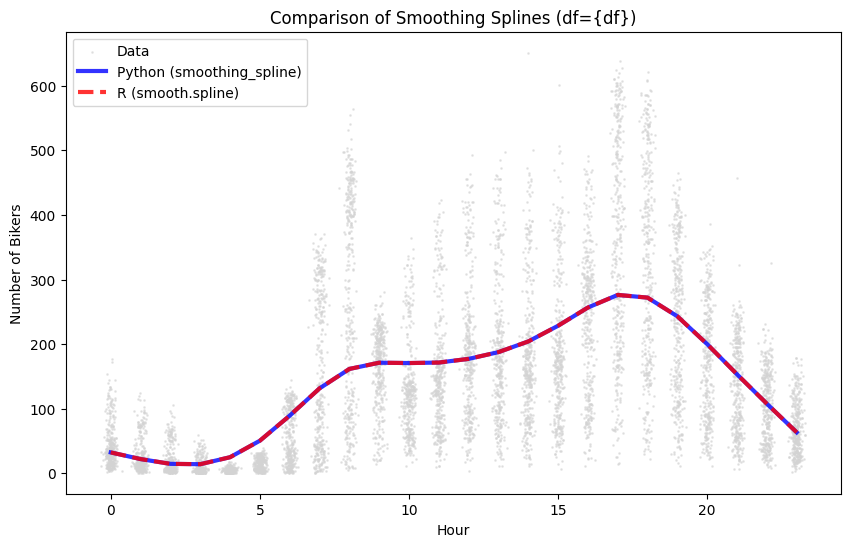

Mean Absolute Difference: 0.003490


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(hr_numeric + np.random.normal(0, 0.1, len(hr_numeric)), bikers, 
            s=1, c='lightgray', alpha=0.5, label='Data')
ax.plot(x_plot, y_py, 'b-', lw=3, label='Python (smoothing_spline)', alpha=0.8)
ax.plot(x_plot, y_r, 'r--', lw=3, label='R (smooth.spline)', alpha=0.8)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Bikers")
ax.set_title("Comparison of Smoothing Splines (df={df})")
ax.legend()
plt.show()

# Numerical comparison
# Note: R might handle repeated x values slightly differently (using weights)
# smoothing_spline handles them naturally in the basis construction.
diff = np.mean(np.abs(y_py - y_r))
print(f"Mean Absolute Difference: {diff:.6f}")

## Speed Comparison

We will compare the execution time for fitting the model.

In [7]:
# Python Timing
t_py = %timeit -o -n 10 -r 3 SplineFitter(x=hr_numeric, df=10).fit(bikers)

# R Timing

5.86 ms ± 40.8 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [8]:
%%R -i hr_numeric -i bikers
library(microbenchmark)
# R Timing
microbenchmark(
  smooth.spline(hr_numeric, bikers, df=10),
  times=10
)

Unit: 

milliseconds

                                       expr

      min

       lq

     mean

   median

 smooth.spline(hr_numeric, bikers, df = 10)

 1.533482

 1.947054

 2.034625

 2.156225

       uq

      max

 neval

 2.171403

 2.197301

    10

## Automatic Tuning with GCV

One of the key features of smoothing splines is the automatic selection of the smoothing parameter ($\lambda$) using Generalized Cross-Validation (GCV).

### In R

R's `smooth.spline` uses GCV (or CV) by default if `df` and `spar` are not specified.

In [9]:
%%R
fit_gcv <- smooth.spline(hr_numeric, bikers, cv=FALSE) # cv=FALSE implies GCV
cat("Selected df (R):", fit_gcv$df, "
")
cat("Selected lambda (R):", fit_gcv$lambda, "
")

Selected df (R):

23.09998

Selected lambda (R):

9.504108e-05

### In Python (smoothing_spline)

The `smoothing_spline` package also supports finding $\lambda$ that minimizes the GCV score via the `solve_gcv` method.

In [10]:
# Initialize fitter with data
# Note: We use the internal C++ fitter for speed if available
fitter = SplineFitter(x=hr_numeric, knots=np.unique(hr_numeric))

# Solve for GCV
best_lam = fitter.solve_gcv(bikers)
print(f"Selected lambda (Python): {best_lam}")

# Get corresponding df
# We can access the internal fitter to compute DF for verification
if fitter._cpp_fitter:
    best_lam_scaled = best_lam / fitter.x_scale_**3
    best_df = fitter._cpp_fitter.compute_df(best_lam_scaled)
    print(f"Selected df (Python): {best_df}")
else:
    best_df = "N/A (C++ extension not available)"

Selected lambda (Python): 1.1524167755954249
Selected df (Python): 23.10044204963742


We can now visualize the optimal fit.

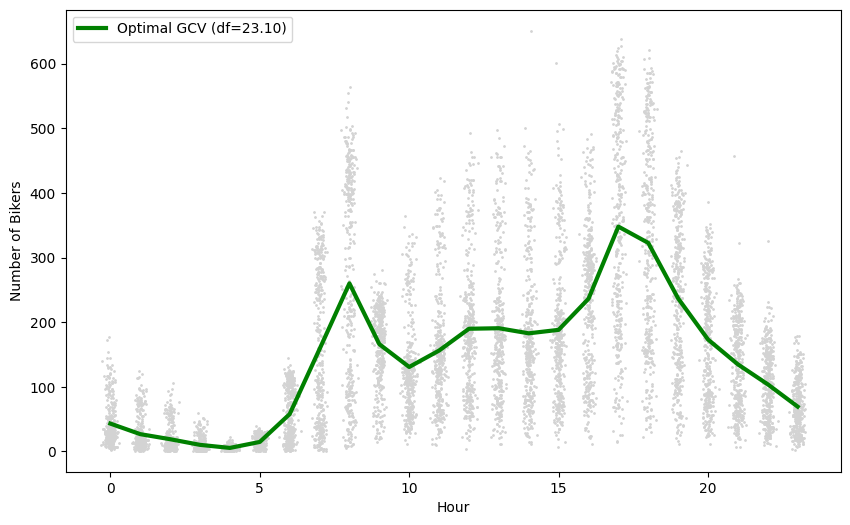

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(hr_numeric + np.random.normal(0, 0.1, len(hr_numeric)), bikers, 
            s=1, c='lightgray')
# fitter is already fitted with best_lam by solve_gcv
ax.plot(x_plot, fitter.predict(x_plot), 'g-', lw=3, label=f'Optimal GCV (df={best_df:.2f})')
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Bikers")
ax.legend()
plt.show()

## Another Example: Log-Transformation

The relationship between hours and bikers might be better modeled on a log scale, as counts are non-negative and variance often increases with the mean.

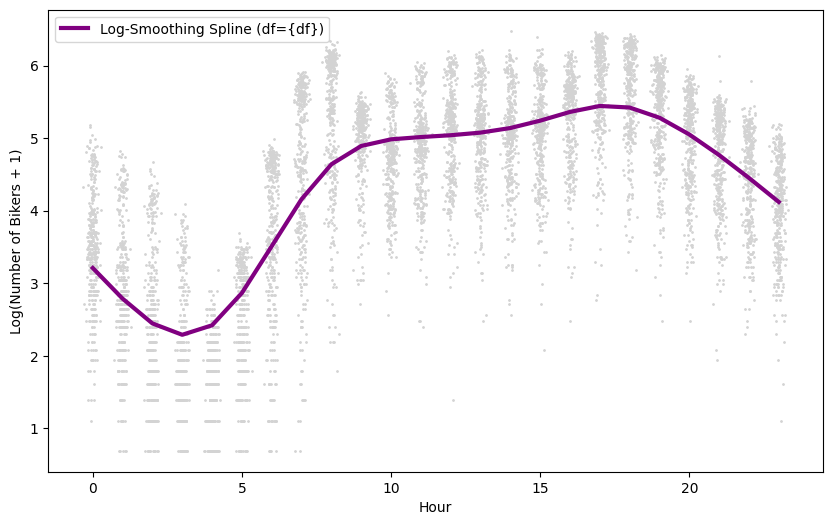

In [12]:
# Fit model on log(bikers)
log_bikers = np.log(bikers + 1) # Add 1 to avoid log(0)
spl_log = SplineFitter(x=hr_numeric, df=df)
spl_log.fit(log_bikers)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(hr_numeric + np.random.normal(0, 0.1, len(hr_numeric)), log_bikers, 
            s=1, c='lightgray')
ax.plot(x_plot, spl_log.predict(x_plot), 'purple', lw=3, label='Log-Smoothing Spline (df={df})')
ax.set_xlabel("Hour")
ax.set_ylabel("Log(Number of Bikers + 1)")
ax.legend()
plt.show()

## Synthetic Speed Comparison (N=500)

Finally, we compare the speed of both implementations on a synthetic dataset with 500 unique $x$ values.

In [13]:
# Synthetic data
n_syn = 500
rng = np.random.default_rng(0)
x_syn = np.sort(rng.uniform(0, 10, n_syn))
y_syn = np.sin(x_syn) + rng.normal(0, 0.1, n_syn)

# Python Timing (using all unique x as knots)
print(f"Python Timing (n={n_syn}, all knots):")
%timeit SplineFitter(x=x_syn, df=10).fit(y_syn)

Python Timing (n=500, all knots):


743 ms ± 9.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%R -i x_syn -i y_syn
library(microbenchmark)
cat(sprintf("R Timing (n=%d):\n", length(x_syn)))

# Fit once to inspect knots
fit_r_syn <- smooth.spline(x_syn, y_syn, df=10, all.knots=TRUE)
n_knots_r <- fit_r_syn$fit$nk
cat(sprintf("Number of knots used by R: %d\n", n_knots_r))

microbenchmark(
  smooth.spline(x_syn, y_syn, df=10),
  times=100
)

R Timing (n=500):


Number of knots used by R: 502


Unit: 

milliseconds

                                 expr

      min

       lq

    mean

   median

 smooth.spline(x_syn, y_syn, df = 10)

 1.017128

 1.027162

 1.04027

 1.032833

       uq

      max

 neval

 1.039956

 1.306849

   100

## Limited knots

R's `smooth.spline` automatically reduces the number of knots when $N > 49$ (typically to around 50-100) to speed up computation. For $N=10000$, `R` uses about 200 knots.

To make a fair speed comparison, we can limit the number of knots in Python as well.

In [15]:
# Python Timing with reduced knots
n_syn = 10000
x_syn = np.sort(rng.uniform(0, 10, n_syn))
y_syn = np.sin(x_syn) + rng.normal(0, 0.1, n_syn)
n_knots_reduced = 200 # Similar to R's behavior
print(f"Python Timing (n={n_syn}, n_knots={n_knots_reduced}):")
%timeit SplineFitter(x=x_syn, df=10, n_knots=n_knots_reduced).fit(y_syn)

Python Timing (n=10000, n_knots=200):


87 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%R -i x_syn -i y_syn
library(microbenchmark)
cat(sprintf("R Timing (n=%d):\n", length(x_syn)))

# Fit once to inspect knots
fit_r_syn <- smooth.spline(x_syn, y_syn, df=10, nknots=200)
n_knots_r <- fit_r_syn$fit$nk
cat(sprintf("Number of knots used by R: %d\n", n_knots_r))

microbenchmark(
  smooth.spline(x_syn, y_syn, df=10),
  times=100
)

R Timing (n=10000):


Number of knots used by R: 202


Unit: 

milliseconds

                                 expr

      min

       lq

     mean

   median

 smooth.spline(x_syn, y_syn, df = 10)

 29.54396

 30.68539

 31.72041

 30.89628

       uq

      max

 neval

 31.67716

 53.50502

   100